#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import panel as pn
import pandas as pd
from sklearn.manifold import TSNE

#### Utils

In [2]:
def generate_3d_spiral(n_points=1000, noise=0.05):
    t = np.linspace(0, 4 * np.pi, n_points)
    x = t * np.cos(t)
    y = t * np.sin(t)
    z = np.linspace(-2, 2, n_points)
    X = np.vstack((x, y, z)).T
    X += noise * np.random.randn(*X.shape)
    return X

In [3]:
def generate_concentric_spheres(n_points=1000, noise=0.02):
    n = n_points // 2
    phi = np.random.uniform(0, np.pi, n)
    theta = np.random.uniform(0, 2 * np.pi, n)

    def sphere_points(r):
        x = r * np.sin(phi) * np.cos(theta)
        y = r * np.sin(phi) * np.sin(theta)
        z = r * np.cos(phi)
        return np.vstack((x, y, z)).T

    inner = sphere_points(1.0) + noise * np.random.randn(n, 3)
    outer = sphere_points(2.0) + noise * np.random.randn(n, 3)

    X = np.vstack((inner, outer))
    y = np.array([0]*n + [1]*n)
    return X, y

In [4]:
def generate_skewed_blobs(n_points=300, seed=42):
    rng = np.random.RandomState(seed)
    means = [np.array([2, 0, 0]), np.array([-2, 0, 0]), np.array([0, 2, 2])]
    covs = [np.diag([1, 0.1, 0.1]),
            np.diag([0.1, 1, 0.1]),
            np.diag([0.1, 0.1, 1])]
    
    X = []
    y = []
    for i, (mean, cov) in enumerate(zip(means, covs)):
        X.append(rng.multivariate_normal(mean, cov, n_points // 3))
        y += [i] * (n_points // 3)
    return np.vstack(X), np.array(y)

## Dimensionality reduction

### PCA
Principal Component Analysis aka PCA reduces the dimensionality of the dataset to the user-determined number of dimensions, 
<br>trying to preserve as much information as possible. Information in this context is viewed as synonymous with variance. 
<br>The new dimensions (called principal components) are linear combinations of the original dimensions (features). 
<br>From geometric point of view, linear combinations effectively mean that we can rotate, scale and sum original features. 
<br>From algebraic point of view, each new feature is calculated like this:
<br>$\text{PC}_i = w_{i1}x_1 + w_{i2}x_2 + w_{i3}x_3 + \dots + w_{in}x_n$


<img src="figs/PCA.gif">

The algorithm goes like this:
1) Standardize the data - center each feature to zero mean and scale to unit variance (especially when your features have very different scales!)
2) Compute the covariance matrix to see how features are correlated with each other. Correlation = duplication of information
3) Find PCs. 1st PC is the one that has max variance, 2nd - the next by variance value, and so on. <br>This calculation is equivalent to calculating eigenvectors (define the direction of the component) and eigenvalues (determine variance) of the covariance matrix.
5) Using eigenvectors and eigenvalues of the top `k` components, create transformation matrix.

In [5]:
X, y = make_blobs(n_samples=300, centers=3, n_features=3, random_state=42)
X = StandardScaler().fit_transform(X) 

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

#### Inspect the original datasets

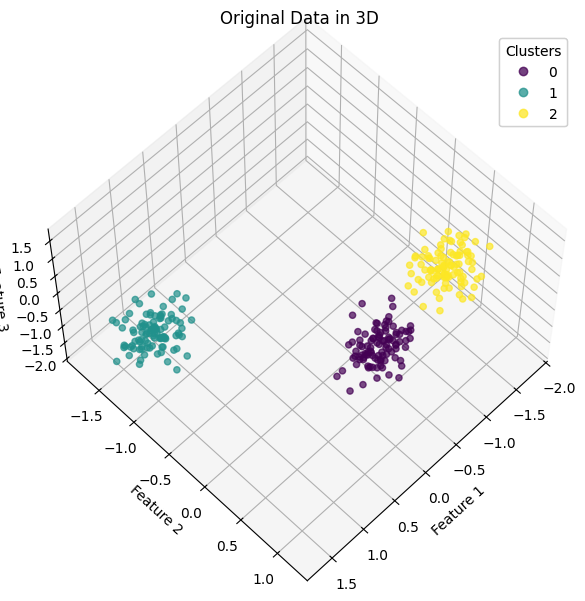

In [6]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis', alpha=0.7)
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

ax.set_title("Original Data in 3D")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
# Set the original viewing angles. You can change these values 
# if your Matplotlib backend doesn't want to do interactivity
ax.view_init(elev=60, azim=45)
plt.tight_layout()
plt.show()


#### Or you can use Plotly

In [7]:
df = pd.DataFrame(X, columns=['Feature 1', 'Feature 2', 'Feature 3'])
df['Cluster'] = y.astype(str)

# Plot
fig = px.scatter_3d(df, x='Feature 1', y='Feature 2', z='Feature 3',
                    color='Cluster', opacity=0.7,width=800)
fig.show()

#### Run PCA

In [8]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

#### PCA projection

In [9]:
def plot_2d_pca(X_pca,y=None,cmap='tab20b'):
    if y is None:
        y = 'blue'
        cmap=None
    fig, ax = plt.subplots(figsize=(6, 5))
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=cmap, alpha=0.7)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    plt.tight_layout()
    plt.show()
    
    print("Explained variance ratio:", pca.explained_variance_ratio_)

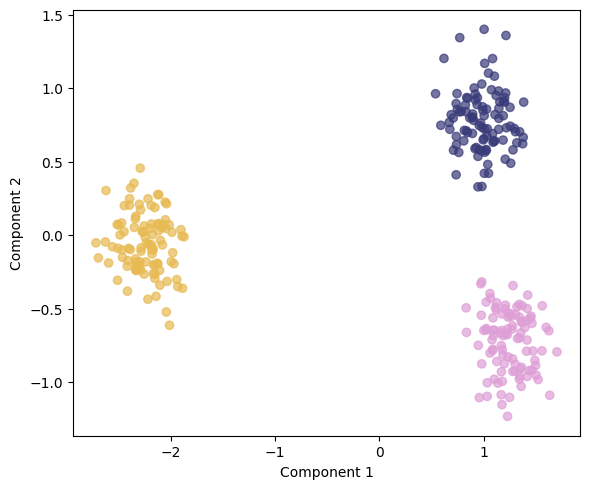

Explained variance ratio: [0.85019211 0.13979792]


In [10]:
plot_2d_pca(X_pca,y)

### Exercise: how well PCA works with non-linear datasets?
1) Using the Utils function, generate several 3d datasets and see in which cases PCA produces meaningful 2D representation, and in which it fails.
2) What about running PCA with 3 components instead of 2?
3) Don't forget about making composite datasets, e.g. intertwined spirals.

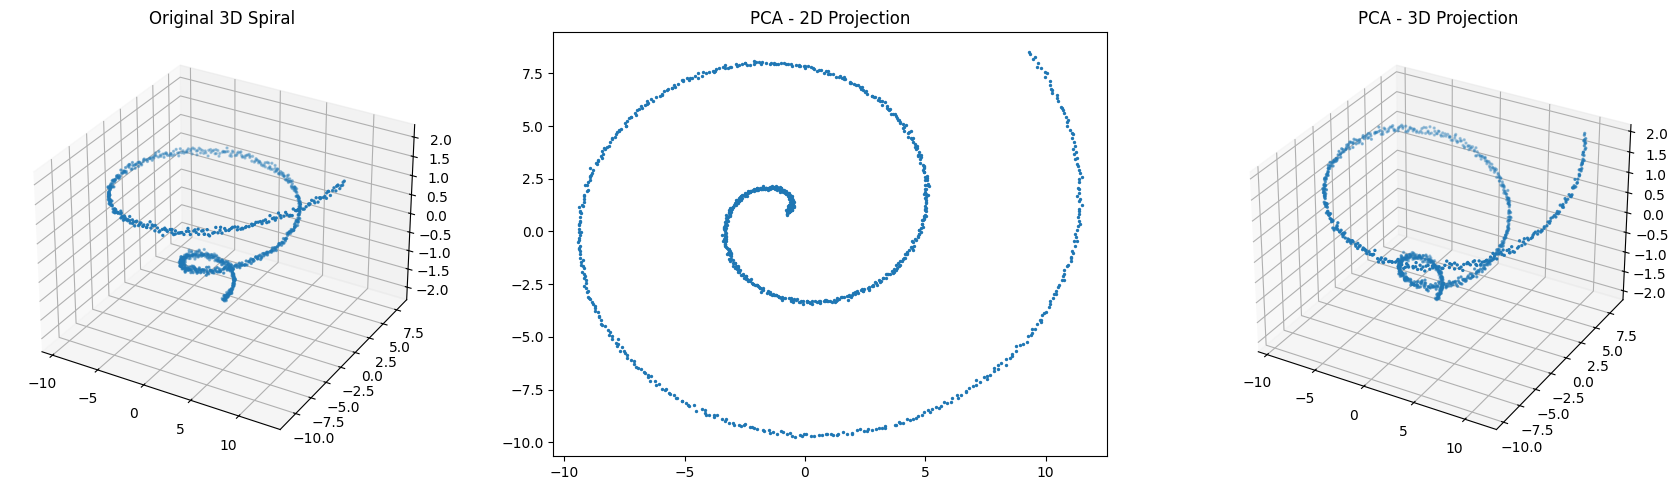

In [29]:
X = generate_3d_spiral()

pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X)

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X)

fig = plt.figure(figsize=(18, 5))

ax = fig.add_subplot(131, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=2)
ax.set_title("Original 3D Spiral")

ax2 = fig.add_subplot(132)
ax2.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], s=2)
ax2.set_title("PCA - 2D Projection")

ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], s=2)
ax3.set_title("PCA - 3D Projection")

plt.tight_layout()
plt.show()


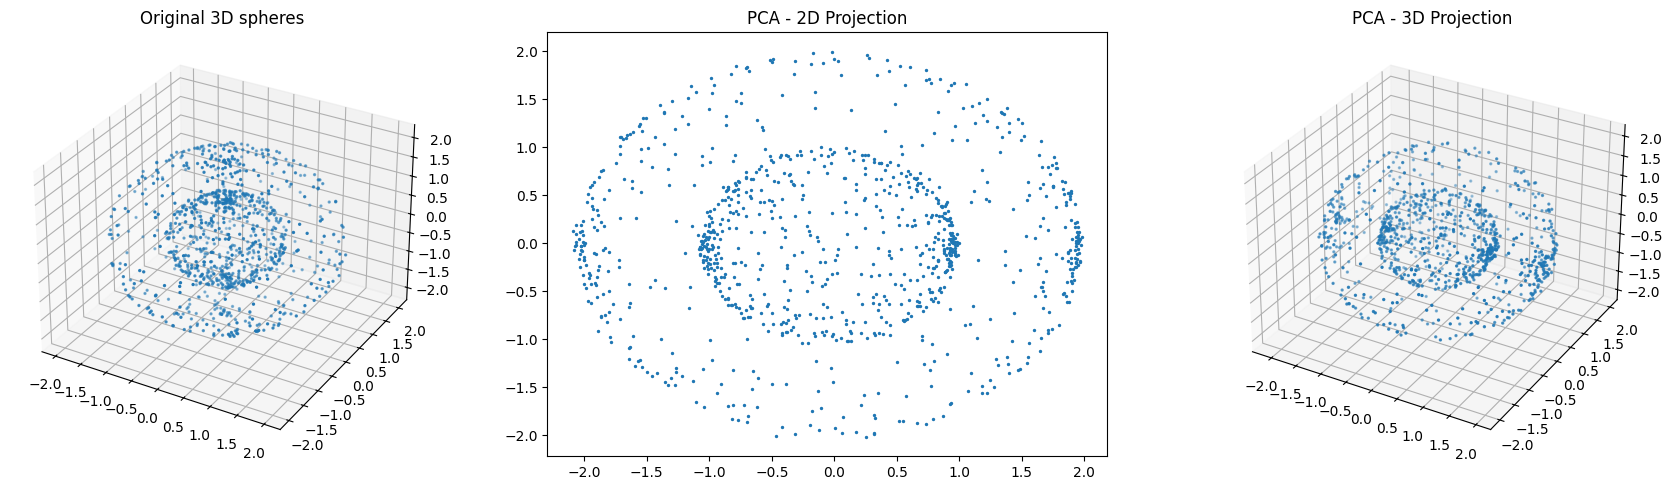

In [31]:
X, y = generate_concentric_spheres()

pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X)

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X)

fig = plt.figure(figsize=(18, 5))

ax = fig.add_subplot(131, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=2)
ax.set_title("Original 3D spheres")

ax2 = fig.add_subplot(132)
ax2.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], s=2)
ax2.set_title("PCA - 2D Projection")

ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], s=2)
ax3.set_title("PCA - 3D Projection")

plt.tight_layout()
plt.show()


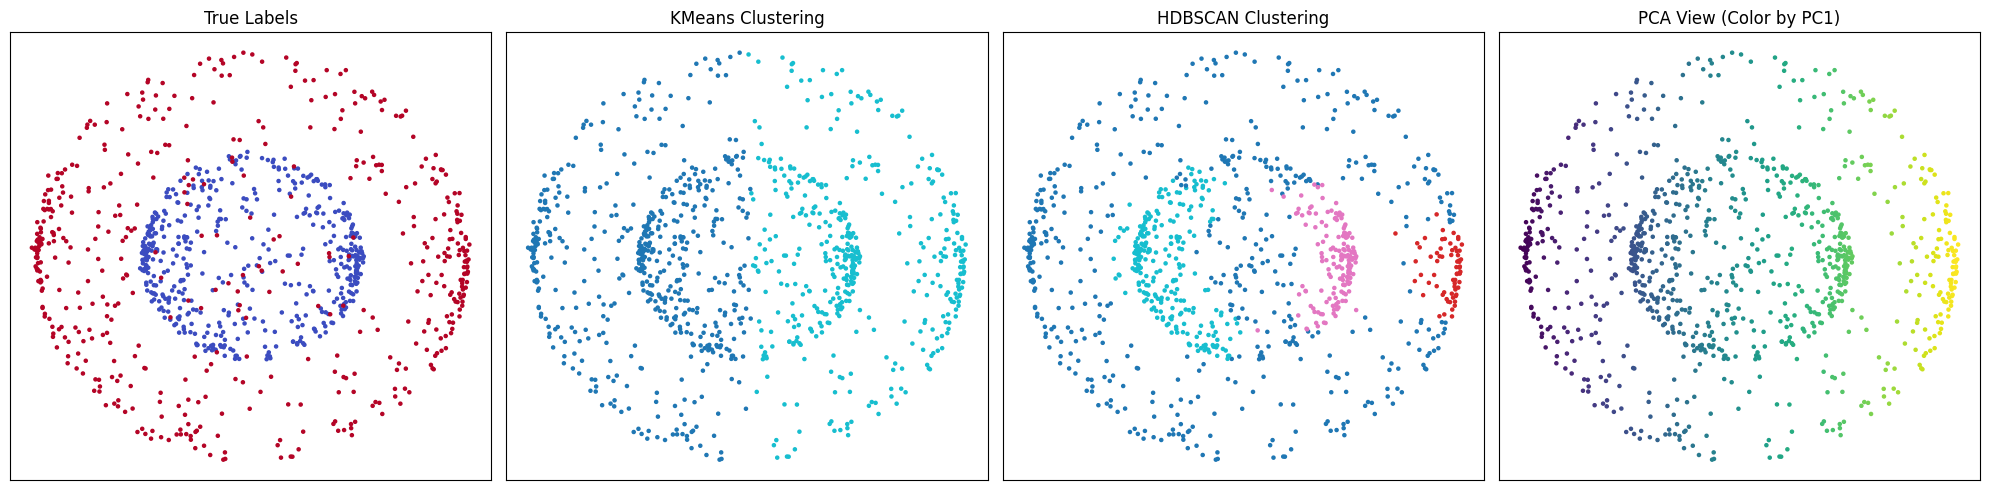

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, HDBSCAN

def generate_concentric_spheres(n_points=1000, noise=0.02):
    n = n_points // 2
    phi = np.random.uniform(0, np.pi, n)
    theta = np.random.uniform(0, 2 * np.pi, n)

    def sphere_points(r):
        x = r * np.sin(phi) * np.cos(theta)
        y = r * np.sin(phi) * np.sin(theta)
        z = r * np.cos(phi)
        return np.vstack((x, y, z)).T

    inner = sphere_points(1.0) + noise * np.random.randn(n, 3)
    outer = sphere_points(2.0) + noise * np.random.randn(n, 3)

    X = np.vstack((inner, outer))
    y = np.array([0]*n + [1]*n)
    return X, y

# Gerar dados
X, true_labels = generate_concentric_spheres()

# Projeção PCA para 2D
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# Aplicar KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_2d)

# Aplicar HDBSCAN
hdb = HDBSCAN(min_cluster_size=50)
hdb_labels = hdb.fit_predict(X_2d)

# Plot comparativo
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Labels verdadeiros
axes[0].scatter(X_2d[:, 0], X_2d[:, 1], c=true_labels, cmap='coolwarm', s=5)
axes[0].set_title("True Labels")

# PCA + KMeans
axes[1].scatter(X_2d[:, 0], X_2d[:, 1], c=kmeans_labels, cmap='tab10', s=5)
axes[1].set_title("KMeans Clustering")

# PCA + HDBSCAN
axes[2].scatter(X_2d[:, 0], X_2d[:, 1], c=hdb_labels, cmap='tab10', s=5)
axes[2].set_title("HDBSCAN Clustering")

# PCA componentes coloridos
axes[3].scatter(X_2d[:, 0], X_2d[:, 1], c=X_2d[:, 0], cmap='viridis', s=5)
axes[3].set_title("PCA View (Color by PC1)")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


### Extra exercise: clustering on 3D
Run Kmeans and/or HDBSCAN on your 3D datasets and figure out what how it breaks them:)

### tSNE

t-distributed Stochastic Neighbor Embedding aka tSNE is a nonlinear dimensionality reduction algorithm. Unlike PCA, it doesn't analyze 
<br>the dataset as a whole, nor tries to maximize the preversed information (variance). Instead it attempts to preserve structures within 
<br>the dataset, and in particular to keep data points that are neighbours in high-dimensional space neighbours in the low-dimensional projection.

Algorithm:
- Measure the distances from each data point to its `k` closest neighbours
- Put the data point of interest in the center of a Gaussian distribution, then put its neighbours on the Gaussian as well, depending <br> on their distances
<img src='figs/tsne.png' width=500>

- Place the data points onto low-dimension space in such a way, that the distributions from high-D space were preserved.
- Shuffle the data points in the low-dimension space until convergence or until `max_iter` value.

The most important parameter of tSNE is `perplexity`, which roughly corresponds to the number of neighbours the algorithm considers 
<br>when calculating distributions to preserve. The lower is `perplexity`, the less neighbours are taken into account and the more
<br>attention the algorithm pays to the details (often at the expense of the representation of global structure).

A 'sibling method' to tSNE, UMAP, pays more attention to the global structure of the dataset. It's also more computationally efficient.

**Sources:**
- Original paper: https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf
- Distill article with lots of great examples: https://distill.pub/2016/misread-tsne/

In [36]:
# t-SNE plot function
def plot_tsne(X, n_components=2, perplexity=30, random_state = 42, max_iter=1000, y=None, cmap='plasma',ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    else:
        fig = ax.figure
    tsne = TSNE(n_components=n_components, random_state=random_state, perplexity=perplexity, init='pca',max_iter=max_iter)
    X_embedded = tsne.fit_transform(X)

    if y is None:
        y = 'blue'
        cmap = None
    ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap=cmap, alpha=0.7)
    plt.tight_layout()
    plt.close(fig)
    return fig

In [37]:
# Creating smaller dataset so that tSNE didn't kill our kernel
X_spiral = generate_3d_spiral(n_points=200)
X_spheres,y_spheres = generate_concentric_spheres(n_points=200)

In [38]:
df = pd.DataFrame(X_spiral, columns=['Feature 1', 'Feature 2', 'Feature 3'])
df['Color'] = [i for i in range(len(df))]

fig = px.scatter_3d(df, x='Feature 1', y='Feature 2', z='Feature 3',
                    color='Color', opacity=0.7,width=800)
fig.show()

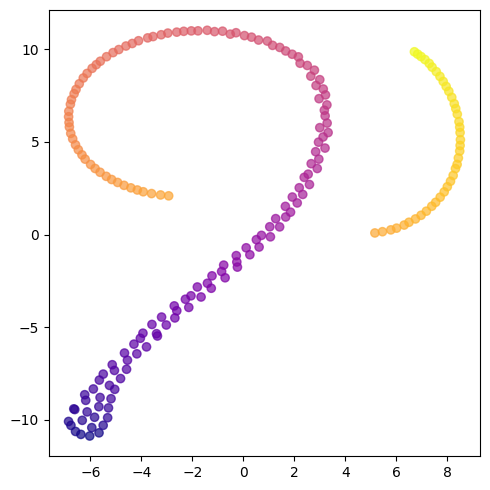

In [39]:
plot_tsne(X_spiral, y=df['Color'])

In [40]:
df = pd.DataFrame(X_spheres, columns=['Feature 1', 'Feature 2', 'Feature 3'])
df['Color'] = y_spheres

fig = px.scatter_3d(df, x='Feature 1', y='Feature 2', z='Feature 3',
                    color='Color', opacity=0.7,width=800)
fig.show()

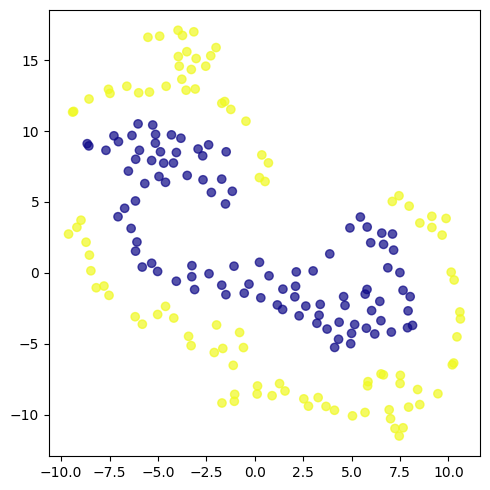

In [41]:
plot_tsne(X_spheres, y=df['Color'])

#### You guessed it: interactivity time (if your laptop can survive it - be careful!)
If not, go check out the Distill paper, it has cool interactive stuff too.

In [96]:
perphexity_slider = pn.widgets.IntSlider(name='perplexity', start=2, end=100, value=30)
max_iter_slider = pn.widgets.IntSlider(name='max_iter', start=250, end=1000, value=500)

img_pane = pn.pane.Matplotlib()

In [97]:
def update_plot(event=None):
    perplexity = perphexity_slider.value
    max_iter = max_iter_slider.value
    log.append(perplexity)
    fig, ax = plt.subplots(figsize=(3,3))

    plot_tsne(X_spiral, y=[i for i in range(len(X_spiral))],perplexity=perplexity,max_iter=max_iter,ax=ax)
    img_pane.object = fig

In [98]:
perphexity_slider.param.watch(update_plot, 'value')
max_iter_slider.param.watch(update_plot, 'value')
layout = pn.Row(pn.Column(perphexity_slider,max_iter_slider),img_pane)
update_plot()

Row
    [0] Column
        [0] IntSlider(end=100, name='perplexity', start=2, value=30)
        [1] IntSlider(end=1000, name='max_iter', start=250, value=500)
    [1] Matplotlib(Figure)
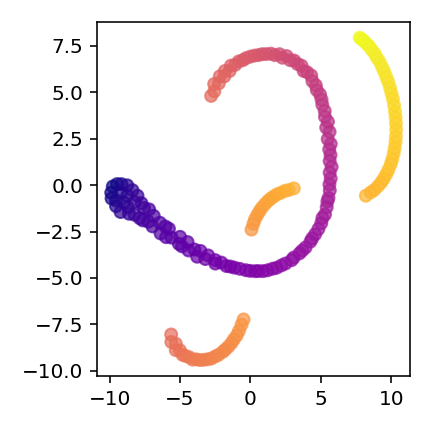

In [99]:
layout.servable()

## Let's get real. MNIST!